# Example usage of widefield in `neuralib.model.rastermap`

seealso [rastermap](https://github.com/MouseLand/rastermap) and [colab example](https://colab.research.google.com/github/MouseLand/rastermap/blob/main/notebooks/rastermap_widefield.ipynb)

In [1]:
import attrs
import numpy as np
import rastermap.utils
from neuralib.io.dataset import load_example_rastermap_wfield
from neuralib.model.rastermap import *
from neuralib.plot import plot_figure, ax_merge
from neuralib.typing import PathLike
from rastermap import Rastermap
from scipy.stats import zscore

### Example of Wide-field dataset pipeline
- Linear treadmill task
- Visual stimulation epoch with circular patch (pink areas in the figure)
- Tracking of behavioral variables. running, velocity

In [2]:
%load_ext autoreload
%autoreload

### Example of Wfield pipeline
- prepare a container for image sequences information and computed singular_vector

In [3]:
@attrs.define
class RasterMapInput:
    """
    `Dimension parameters`:

        W = image width

        H = image height

        T = number of image pulse

        C = number of components after SVD reduction

        S = number of stimulation (optional)

    """

    height: int
    """Image height H"""
    width: int
    """Image width W"""

    # singular vector
    n_components: int
    """Number of components after SVD reduction"""
    sv: np.ndarray
    """Singular values. `Array[float, C]`"""
    Vsv: np.ndarray
    """Right singular vector. `Array[float, [T, C]]`"""
    U: np.ndarray
    """left singular vector. `Array[float, [W * H, C]]`"""

    image_time: np.ndarray
    """1D wide-field imaging acquisition time. `Array[float, T]`"""

    position: np.ndarray
    """1D animal position in the environment. `Array[float, T]`"""
    velocity: np.ndarray
    """1D animal velocity in the environment. `Array[float, T]`"""
    visual_stim_time: np.ndarray
    """2D on-off visual stimulation time. `Array[float, [S,2]]`"""

    @property
    def xpos(self) -> np.ndarray:
        x = np.arange(self.width)
        y = np.arange(self.height)
        return np.meshgrid(x, y)[0]

    @property
    def ypos(self) -> np.ndarray:
        x = np.arange(self.width)
        y = np.arange(self.height)
        return np.meshgrid(x, y)[1]

    @property
    def visual_stim_start(self) -> float:
        return float(self.visual_stim_time[0, 0])

    def visual_stim_trange(self, trange: tuple[float, float]) -> np.ndarray:
        """select visual stim time range segments

        :return (nStim, 2)
        """
        vt = self.visual_stim_time  # (N,2) -> (N*2)
        start_idx, end_idx = np.searchsorted(vt.ravel(), list(trange))

        # map to (N, 2)
        start_stim_idx = int(start_idx // 2)
        end_stim_idx = int(end_idx // 2)

        if start_idx % 2 != 0:
            vt[start_stim_idx, 0] = trange[0]

        if end_idx % 2 != 0:
            vt[end_stim_idx, 1] = trange[1]

        return vt[start_stim_idx: end_stim_idx]

In [4]:
# Prepare config dict
DEFAULT_WFIELD_RASTER_OPT: RasterOptions = {
    'n_clusters': 100,
    'locality': 0.5,
    'time_lag_window': 10,
    'grid_upsample': 10
}

In [5]:
def run_rastermap_wfield(dat: RasterMapInput,
                         ops: RasterOptions | None = None,
                         neuron_bins: int = 500,
                         **kwargs) -> RasterMapResult:
    if ops is None:
        ops = DEFAULT_WFIELD_RASTER_OPT

    ops['n_PCs'] = dat.n_components

    model = Rastermap(
        n_clusters=ops['n_clusters'],
        n_PCs=ops['n_PCs'],
        locality=ops['locality'],
        time_lag_window=ops['time_lag_window'],
        grid_upsample=ops['grid_upsample'],
        **kwargs
    ).fit(
        Usv=dat.U * dat.sv,  # left singular vectors weighted by the singular values
        Vsv=dat.Vsv  # right singular vectors weighted by the singular values
    )

    embedding = model.embedding
    isort = model.isort
    Vsv_sub = model.Vsv  # these are the PCs across time with the mean across voxels subtracted

    U_sn = rastermap.utils.bin1d(dat.U[isort], bin_size=neuron_bins, axis=0)  # bin over voxel axis
    sn = U_sn @ Vsv_sub.T
    sn = zscore(sn, axis=1)

    ret = RasterMapResult(
        filename='',  # replace to user specific
        save_path='',  # replace to user specific
        isort=isort,
        embedding=embedding,
        ops=ops,
        user_clusters=[],
        super_neurons=sn
    )

    return ret


# =============================== #
# Plot cluster and Voxel colormap #
# =============================== #

def plot_rastermap_sort(dat: RasterMapInput,
                        raster: RasterMapResult,
                        trange: tuple[int, int]):
    tmask = np.logical_and(trange[0] <= dat.image_time, dat.image_time <= trange[1])
    time = dat.image_time[tmask]

    with plot_figure(None, 11, 20, gridspec_kw={'wspace': 1, 'hspace': 1}, tight_layout=False) as _ax:
        # position
        ax1 = ax_merge(_ax)[0, :-1]
        ax1.plot(time, dat.position[tmask], color='k')
        ax1.axis("off")
        ax1.set_title("position", color='k')

        # running speed
        ax2 = ax_merge(_ax)[1, :-1]
        ax2.plot(time, dat.velocity[tmask], color='k')
        ax2.axis("off")
        ax2.set_title("running speed", color='k')
        ax2.sharex(ax1)

        # superneuron
        ax3 = ax_merge(_ax)[2:, :-1]
        ax3.sharex(ax1)
        ax3.imshow(raster.super_neurons[:, tmask],
                   cmap="gray_r",
                   vmin=0,
                   vmax=0.8,
                   aspect="auto",
                   extent=(trange[0], trange[1], raster.n_super, 0))
        ax3.set(xlabel="time(s)", ylabel='superneurons')

        # visual stim
        if dat.visual_stim_start <= trange[1]:
            for v in dat.visual_stim_trange(trange=trange):
                ax3.axvspan(v[0], v[1], color='mistyrose', alpha=0.6)

        # disable
        ax4 = ax_merge(_ax)[:2, -1]
        ax4.axis('off')

        # color bar
        ax4 = ax_merge(_ax)[2:, -1]
        ax4.imshow(np.arange(0, raster.n_super)[:, np.newaxis], cmap="gist_ncar", aspect="auto")
        ax4.axis("off")


def plot_raster_voxel(dat: RasterMapInput,
                      raster: RasterMapResult,
                      output: PathLike | None = None):
    with plot_figure(output) as ax:
        ax.scatter(dat.xpos,
                   dat.ypos,
                   s=1, c=raster.embedding, cmap="gist_ncar", alpha=0.25)
        ax.invert_yaxis()
        ax.set(xlabel='X position (um)', ylabel='Y position')
        ax.set_aspect('equal')

In [6]:
cache = load_example_rastermap_wfield()  # Replace to your own input data: RastermapInput(...)

raster_input = RasterMapInput(
    height=cache['height'],
    width=cache['width'],
    n_components=cache['n_components'],
    sv=cache['sv'],
    Vsv=cache['Vsv'],
    U=cache['U'],
    position=cache['position'],
    velocity=cache['velocity'],
    image_time=cache['image_time'],
    visual_stim_time=cache['visual_stim_time']
)

In [7]:
res = run_rastermap_wfield(raster_input)

data normalized, 0.08sec
sorting activity: 285534 valid samples by 9626 timepoints
100 clusters computed, time 52.52sec
clusters sorted, time 61.55sec
clusters upsampled, time 63.81sec
rastermap complete, time 63.83sec


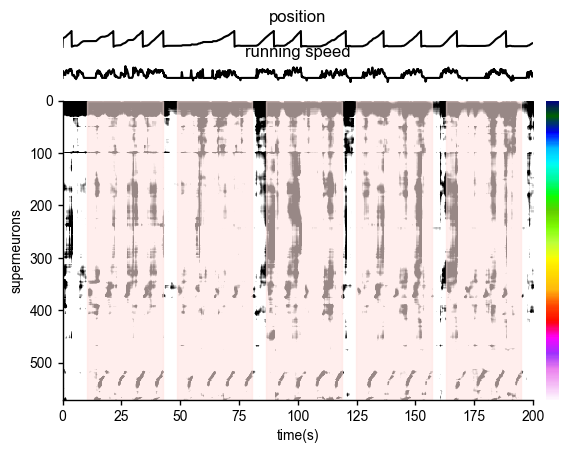

In [8]:
plot_rastermap_sort(raster_input, res, trange=(0, 200))

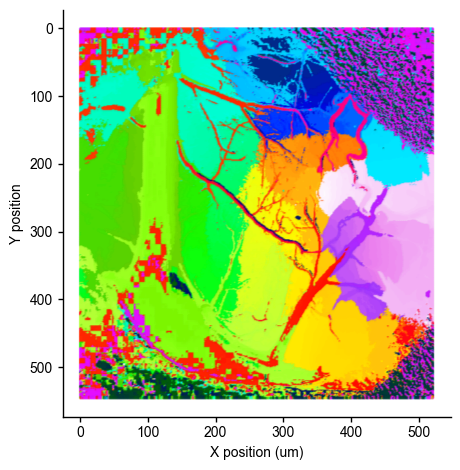

In [9]:
plot_raster_voxel(raster_input, res)